# 2 Components Data

In [1]:
import numpy as np
import time

from ml4pd import components
from ml4pd_utils.utils import prep_dist
from ml4pd.aspen_units import Distillation
from ml4pd.streams import MaterialStream

input_molecules = prep_dist.get_mol_labels()
components.set_components(input_molecules['name'].to_list())

raw_data = prep_dist.get_test_val_data(compositions=[2], dates=['220803'])
data = prep_dist.add_name_columns(raw_data, input_molecules[['name', 'mol']])
data = prep_dist.add_flow_perc(data)
data = prep_dist.rename_flowrate_columns(data)

## Benchmark Data Info

In [2]:
input_molecules.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25
name,water,acetone,2-butanone,3-pentanone,3-hexanone,4-heptanone,4-octanone,5-nonanone,5-decanone,6-undecanone,6-dodecanone,6-tridecanone,7-tetradecanone,8-pentadecanone,acetic acid,propionic acid,lactic acid,n-butyric acid,isobutyric acid,succinic acid,n-valeric acid,isovaleric acid,n-hexanoic acid,n-heptanoic acid,n-octanoic acid
mol,H2O,C3-ONE,C4-ONE,C5-ONE,C6-ONE,C7-ONE,C8-ONE,C9-ONE,C10-ONE,C11-ONE,C12-ONE,C13-ONE,C14-ONE,C15-ONE,C2-VFA-1,C3-VFA-1,C3-VFA-2,C4-VFA-1,C4-VFA-2,C4-VFA-3,C5-VFA-1,C5-VFA-2,C6-VFA-1,C7-VFA-1,C8-VFA-1


In [3]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
flowrate_feed_A,10000.0,0.498520,0.221764,3.408900e-04,0.359248,0.495614,0.638140,0.999865
flowrate_feed_B,10000.0,0.501480,0.221764,1.349100e-04,0.361860,0.504386,0.640752,0.999659
ratio_reflux,10000.0,3.928908,5.426635,1.000607e-02,0.089109,0.750617,6.880775,19.995348
ratio_boilup,10000.0,3.953224,5.400875,1.000763e-02,0.087087,0.806330,6.918177,19.982980
pressure_atm,10000.0,5.266592,6.637799,1.000790e-01,0.370932,1.626350,8.837538,23.958780
no_stages,10000.0,21.704400,13.971569,2.000000e+00,7.000000,22.000000,36.000000,40.000000
feed_pressure,10000.0,5.266593,6.637799,1.000800e-01,0.370933,1.626351,8.837539,23.958781
feed_stage,10000.0,10.869200,7.010535,1.000000e+00,4.000000,11.000000,18.000000,20.000000
vapor_fraction,10000.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
flowrate_bott_A,10000.0,0.303381,0.258241,1.419866e-70,0.055918,0.274733,0.493853,0.999955


## Time Benchmark

In [4]:
times = []
for i in range(0, 10):
    start_time = time.time()
    feed_stream = MaterialStream(stream_type="feed")(
        vapor_fraction=data['vapor_fraction'].to_list(),
        pressure=data['feed_pressure'].to_list(),
        molecules=prep_dist.get_name_columns(data).to_dict('list'),
        flowrates=prep_dist.get_flowrate_columns(data).to_dict('list'),
    )
    
    dist_col = Distillation(
        no_stages = data['no_stages'].to_list(),
        feed_stage =  data['feed_stage'].to_list(),
        pressure = data['pressure_atm'].to_list(),
        reflux_ratio = data['ratio_reflux'].to_list(),
        boilup_ratio = data['ratio_boilup'].to_list(),
        verbose=False,
        fillna=False
    )

    bott_stream, dist_stream = dist_col(feed_stream)
    
    times.append(time.time() - start_time)

ordered_data = prep_dist.sort_targets_by_weight(data, feed_stream._mw_idx)

average = np.mean(times).round(2)
std = np.std(times).round(2)

print(f"{len(data)} data pts take {average} +/- {std} seconds to predict.")

10000 data pts take 2.11 +/- 0.43 seconds to predict.


## Classifier Benchmark

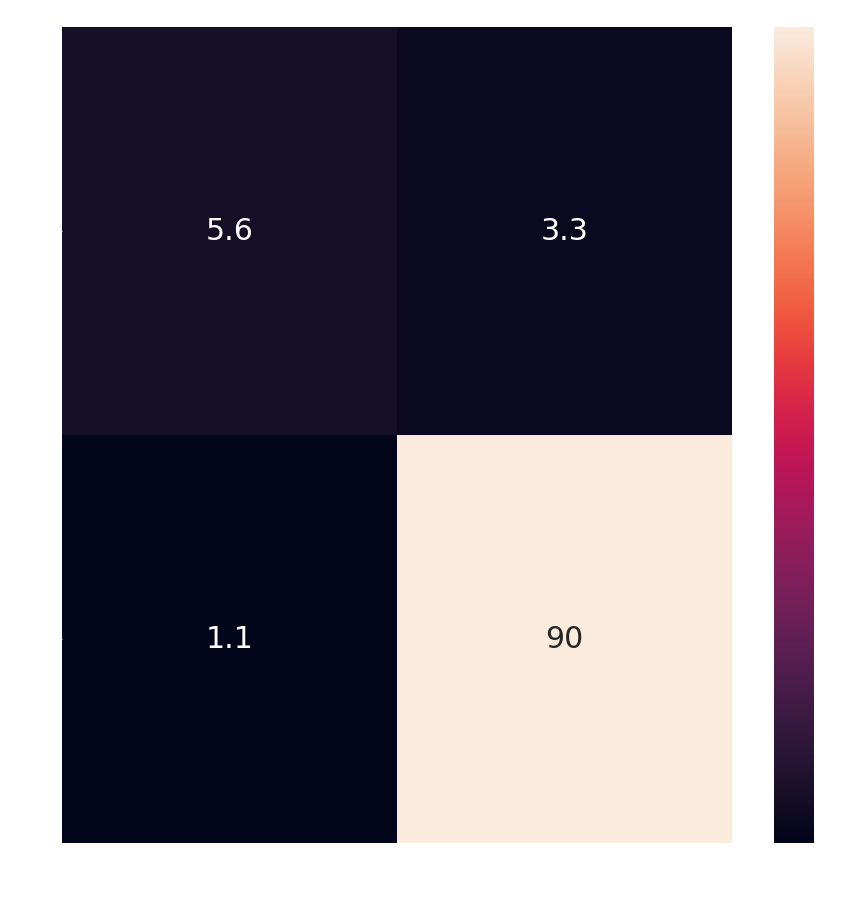

In [5]:
ok_idx = np.array(ordered_data[ordered_data['Status'] == 'OK'].index)
prep_dist.plot_confusion_matrix(ordered_data, dist_col.status)

## Flowrates Benchmark

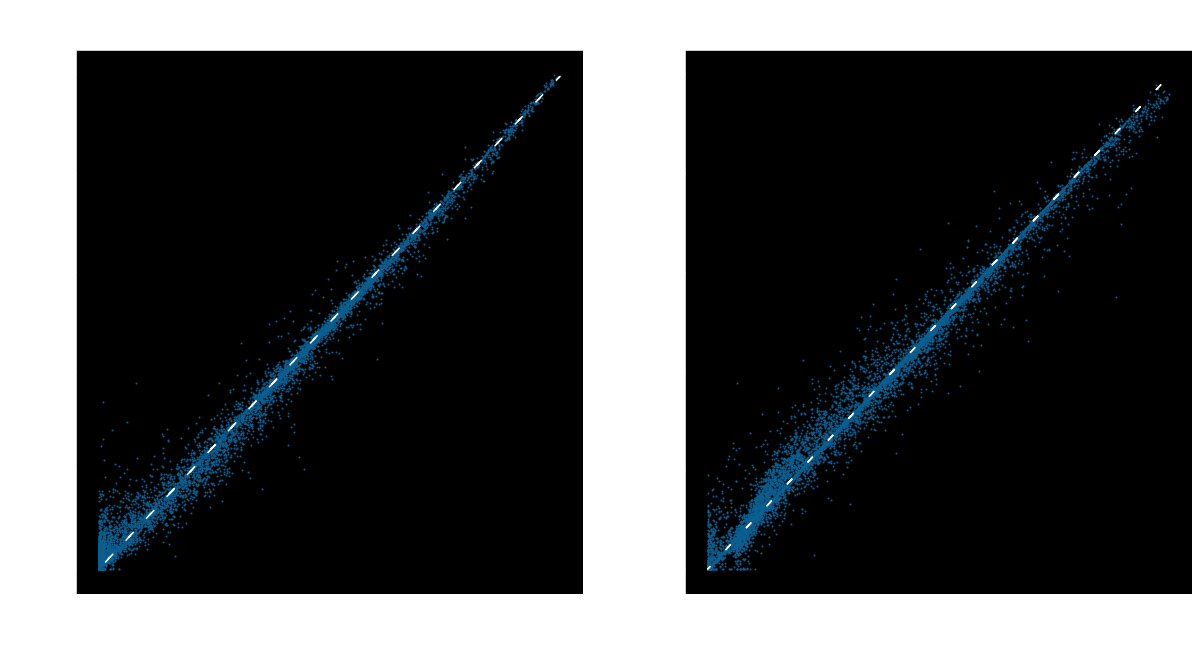

In [6]:
prep_dist.plot_flow(
    all_true=ordered_data,
    y_pred=bott_stream.flow,
    data_slice={
        'Status': 'OK',
    }
)

## Duty Benchmark

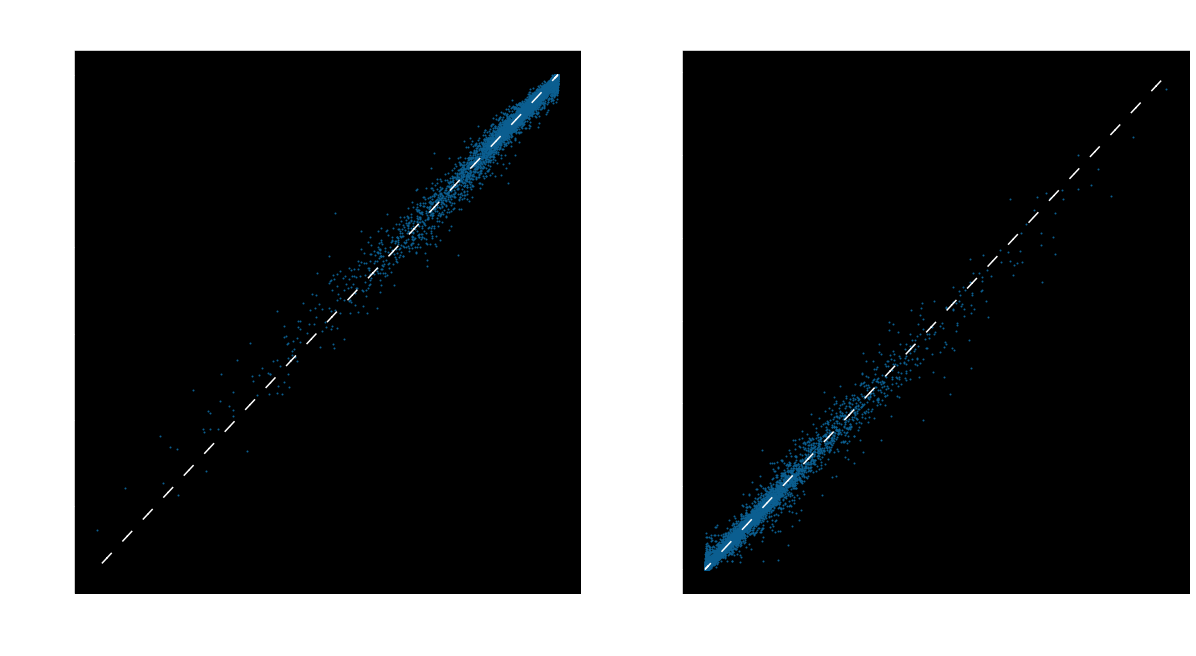

In [7]:
prep_dist.plot_duty(all_true=ordered_data, dist_col=dist_col, data_slice={"Status": "OK"})

## Temperature Benchmark

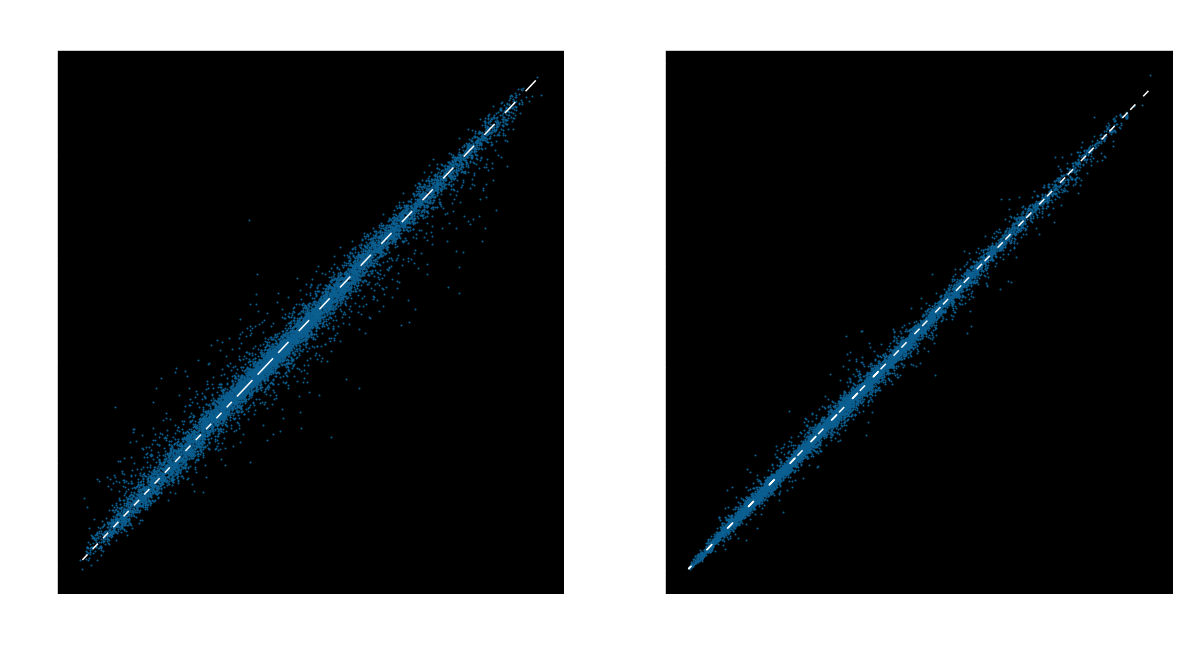

In [8]:
prep_dist.plot_temp(all_true=ordered_data, bott_stream=bott_stream.temperature, dist_stream=dist_stream.temperature, data_slice={'Status': 'OK'})

## Mean Absolute Errors

In [9]:
prep_dist.evaluate_flow(
    all_true=ordered_data, 
    y_pred=bott_stream.flow,
    metric='mae',
    data_slice={"Status": "OK"}
)

,flowrate_bott_A,flowrate_bott_B,mean,count
0,0.014588,0.01842,0.016504,9107


In [10]:
prep_dist.evaluate_duty(
    all_true=ordered_data, 
    dist_col=dist_col, 
    metric='mae',
    data_slice={"Status": "OK"}
)

,condensor_duty,reboiler_duty,mean,count
0,4540.91079,4650.349281,4595.630035,9107


In [11]:
prep_dist.evaluate_temp(
    all_true=ordered_data, 
    bott_stream=bott_stream.temperature, 
    dist_stream=dist_stream.temperature, 
    data_slice={'Status': 'OK'},
    metric="mae"
)

,bott_temp,dist_temp,mean,count
0,8.867314,4.247528,6.557421,9107
